<a href="https://colab.research.google.com/github/annvorosh/GB/blob/Alg_AD/Alg_AD_L6gb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Урок 6. Градиентный бустинг. AdaBoost

## Практическое задание

### 1. Для реализованной модели градиентного бустинга постройте графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделайте выводы о зависимости ошибки от этих параметров.


## Реализация алгоритма градиентного бустинга

In [ ]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np


Используем один из «игрушечных» датасетов из той же библиотеки.

In [ ]:
from sklearn.datasets import load_diabetes

In [ ]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [ ]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже считаются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [ ]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ её производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем её также в виде функции — коэффициент 2 можно отбросить.

In [ ]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [ ]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):

    # Деревья будем записывать в список
    trees = []

    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []

    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль,
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)

            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)

            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))

            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)

    return trees, train_errors, test_errors

In [ ]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)


    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [ ]:
def get_error_plot(depth_tree_set):

    for i in range(len(depth_tree_set)):
        depth = depth_tree_set[i][0]
        n_trees = len(depth_tree_set[i][1])
        train_err = depth_tree_set[i][2]
        test_err = depth_tree_set[i][3]

        plt.xlim(0, n_trees)
        plt.plot(list(range(n_trees)), train_err, label=f'Train error\ndepth={depth}')
        plt.plot(list(range(n_trees)), test_err, label=f'Test error\ndepth={depth}')

        plt.grid(True)
        plt.legend(loc='upper right')
        plt.xlabel('N_trees')
        plt.ylabel('MSE')
        plt.show()

def n_trees_depth(n_trees_max, max_depth, eta = 0.1):
    coefs = [1] * n_trees_max
    depth_tree_set = []
    for d in max_depth:
        trees, train_errors, test_errors = gb_fit(n_trees_max, d, X_train, X_test, y_train, y_test, coefs, eta)
        depth_tree_set.append([d, trees, train_errors, test_errors])
    get_error_plot(depth_tree_set)
    return depth_tree_set

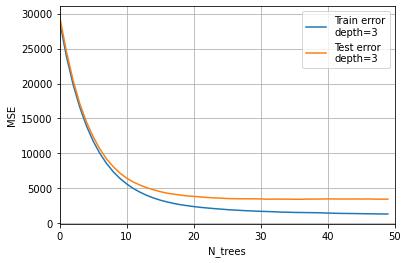

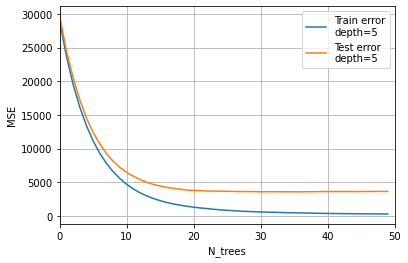

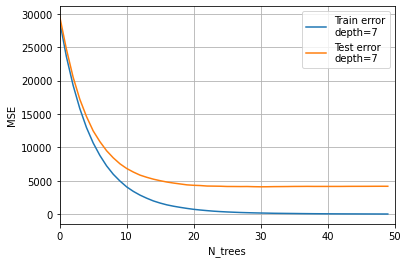

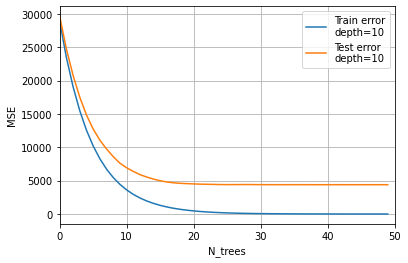

In [ ]:
n_trees_max = 50
max_depth =  np.array([3, 5, 7, 10])
sets = n_trees_depth(n_trees_max, max_depth)

ВЫВОДЫ:

С увеличением числа деревьев в какой-то момент качество работы градиентного бустинга не меняется существенно.

При увеличением глубины деревьев в какой-то момент качество работы градиентного бустинга на тесте начинает ухудшаться.

### 2. Модифицируйте реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки примите равным 0.5. Сравните на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

Взятие случайных подвыборок обучающего набора данных, метод, называемый стохастическим градиентным повышением, также может помочь предотвратить переобучение. Этот метод существенно снижает силу корреляции между деревьями.

In [ ]:
import random

def get_bootstrap(data, labels, N, size):
    n_samples = int(data.shape[0] * size)
    bootstrap = []

    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)

        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))

    return bootstrap


In [ ]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):

    bootstrap = get_bootstrap(X_train, y_train, n_trees, 0.5)

    # Деревья будем записывать в список
    trees = []

    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []

    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        boot_X_train, boot_y_train = bootstrap[i]

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль,
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(boot_X_train, boot_y_train)

            train_errors.append(mean_squared_error(boot_y_train, gb_predict(boot_X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(boot_X_train, trees, coefs, eta)

            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(boot_y_train, target))

            train_errors.append(mean_squared_error(boot_y_train, gb_predict(boot_X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)

    return trees, train_errors, test_errors

In [ ]:
def n_trees_depth_sgb(n_trees_max, max_depth, eta = 0.1):
    coefs = [1] * n_trees_max
    depth_tree_set = []
    for d in max_depth:
        trees, train_errors, test_errors = sgb_fit(n_trees_max, d, X_train, X_test, y_train, y_test, coefs, eta)
        depth_tree_set.append([d, trees, train_errors, test_errors])
    get_error_plot(depth_tree_set)
    return depth_tree_set

In [ ]:
def get_error_plot(depth_tree_set):
    plt.figure(figsize=(15, 10))
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    for i in range(len(depth_tree_set)):
        depth = depth_tree_set[i][0]
        n_trees = len(depth_tree_set[i][1])
        train_err = depth_tree_set[i][2]
        test_err = depth_tree_set[i][3]

        plt.xlim(0, n_trees)
        plt.plot(list(range(n_trees)), train_err, label=f'train error, depth {depth}')
        # plt.plot(list(range(n_trees)), test_err, label=f'test error, depth {depth}')

    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()

    plt.figure(figsize=(15, 10))
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    for i in range(len(depth_tree_set)):
        depth = depth_tree_set[i][0]
        n_trees = len(depth_tree_set[i][1])
        train_err = depth_tree_set[i][2]
        test_err = depth_tree_set[i][3]

        plt.xlim(0, n_trees)
        # plt.plot(list(range(n_trees)), train_err, label=f'train error, depth {depth}')
        plt.plot(list(range(n_trees)), test_err, label=f'test error, depth {depth}')

    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()

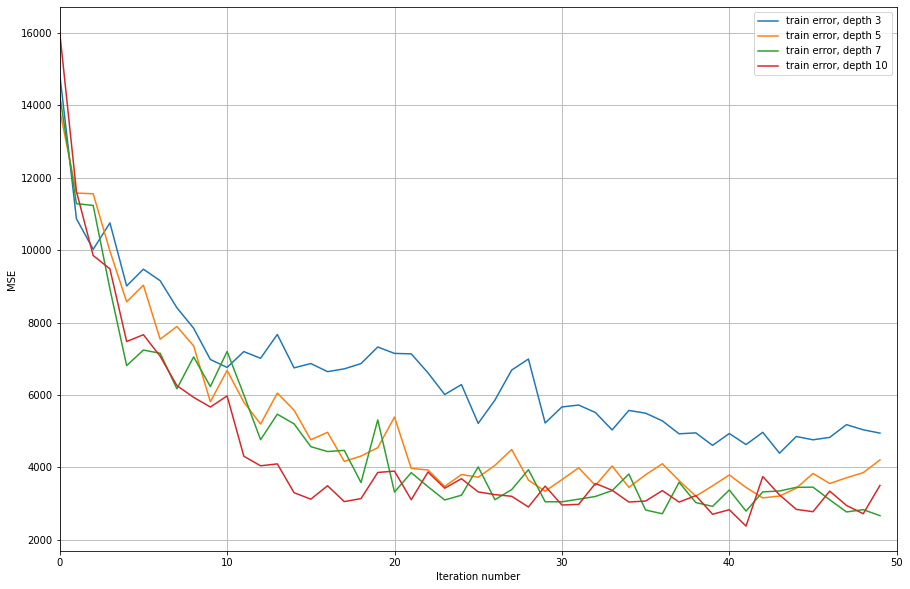

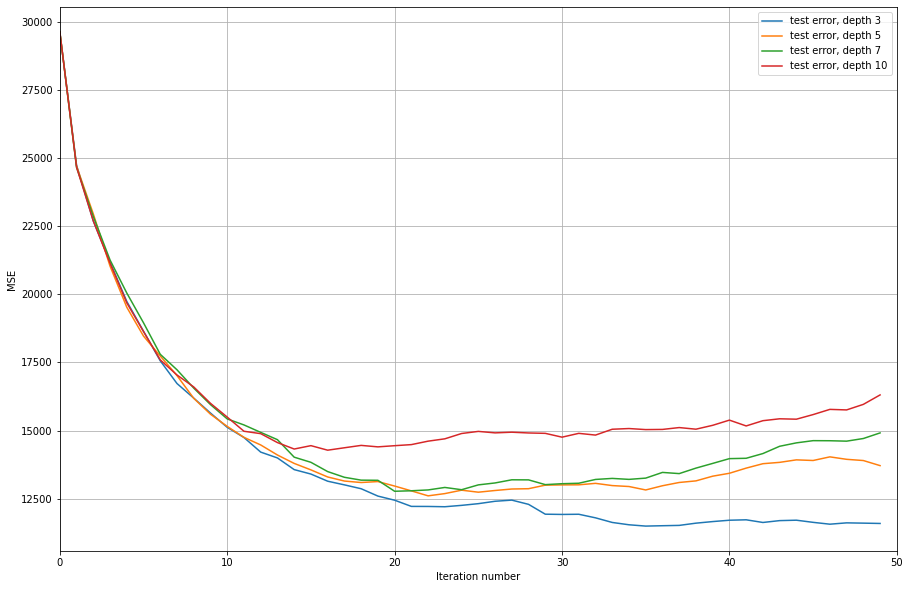

In [ ]:
n_trees_max = 50
max_depth =  np.array([3, 5, 7, 10])
sets = n_trees_depth_sgb(n_trees_max, max_depth)

При увеличением глубины деревьев в какой-то момент на тестовых данных ошибка начинает возрастать.